# OpenRA analysis

> we have a lot of potentially interesting info in our master sqlite database, but no proper ways to visualise or mine it.  It would be awesome if you could write a jupyter notebook that pulled out some useful stats, and then if that works out we could pull out the popular (not necessarily the same as useful!) stats into a script that runs on a cron job to output a json file that we can then plot as part of http://www.openra.net/players/

> There are two main tables with the most interesting data:

> `finished`: holds the records of completed multiplayer matches.  From this it would be good to get a handle on the most popular servers partitioned by mod and host (people usually host multiple on one machine or multiple vms with similar ips), and something like the most popular maps this week / month / release would be great for the public stats page.  Info on a map can be queried from its id using http://resource.openra.net/map/hash/<map hash>.

> `sysinfo` holds all the data from our system information survey.  The boring but most useful stuff would be to aggregate stats on mono/.net and GL versions, plus screen resolutions and display scales. Will need to do some ugly parsing to get just the useful parts out of the version strings.  The OS share would be another good stat for the players page, as well as the number of people who have launched the game in the last <time>.

> Integrate stats from github

## Previous work

Stats are only available when users submit information, which is what we have.

* OS split (windows/mac/linux)
* Cumulative number of players
* Language settings
* Most popular mod
* Most popular mod by language setting
* Most popular map
* Match length

## Available information

It seems all tables have an `id` parameter, which is autoincrementing and is probably meaningless. I shall ignore it for the purposes of this analysis. There are no foreign keys or other indexes so cross-table matching is a little ad-hoc.

### `servers`

* name - name of the server
* address - ip address of the server
* players - number of players on the server
* state - either 1 or 2
* ts - timestamp
* map - hash of the map id, working for some but not all, 118 maps in total
* mods - mod and version
* bots - number of bots playing
* spectators - number of spectators (only 0, 1 or 8 values used)
* maxplayers - maximum number of players
* protected - boolean
* started - human readable time the game was started (note not the same as `ts`)

### `finished`

The records of completed multiplayer matches. Good to track stats for games which successfully complete

* game_id - integer assigned to a game. could be a way to match between the `finished` table and the `started` table.
* name - name of the game
* address - ip address (of the server?), only ~20% of the ip addresses match the `server` ip addresses
* map - map the game was played on, probably links with the `map_stats` table
* game_mod - mod played, not including version
* version - version played; can be matched with `servers` table with `select game_mod || '@' || version from finished`
* protected - boolean
* started - datetime of game start
* finished - datetime of game end

### `map_stats`

Statistics for each map. Note this is essentially just caching a query on the finished games, e.g.

```sql
select map, count(*) as played_counter from finished group by map
```

* map - hash of the map
* played_counter - number of games on this map
* last_change - date of the last game played

### `started`

Info about games that were started but not necessarily finished. Common columns with `finished` are listed above, but new columns are:

* players - number of players
* spectators - number of spectators
* bots - number of bots

### `clients`

* address - ip address of the client
* client - username
* ts - timestamp of _something_...

### `sysinfo`

System info

* system_id - UUID of something
* updated - timestamp of last client update
* platform - OSX/Windows/Linux
* os - kernel version or windows version; kernel version includes OSX kernels
* runtime - either .NET CLR or Mono, with version number
* gl - opengl version
* lang - language of client
* version - version of the game used to collect the data
* mod - mod used, more than just the core 3 mods
* modversion - version of the mod used
* x64 - boolean for 64 bit mode
* windowsize - game resolution
* windowscale - scaling; (some entries have commas in which are the same as with decimal places with european languages)
* sysinfoversion - either 1 or 2

## Ideas

* number of games started but not finished (30000 started but not finished)
* swearing in game names
* breakdown of the versions used
* analysis of people using bots

Before we get started, let's import some packages so we have them available for the rest of the notebook.

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload

%autoreload 1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn.apionly as sns
from IPython.display import Image

# Some utils code, which is autoreloaded whenever code from it is called.
%aimport utils

plt.style.use('ggplot')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Now we think about what we want to know. First we start by re-creating the previous work done.

## Re-creating the previous work

To recap, the [previous analysis][1] investigated these things:

* OS split (windows/mac/linux)
* Cumulative number of players
* Language settings
* Most popular mod
* Most popular mod by language setting
* Most popular map
* Match length

[1]: http://www.openra.net/news/2017-01-stats-post/

### OS split

In [11]:
display(Image(url='http://www.openra.net/images/news/20170110-stats-downloads-vs-users.png'))

In [12]:
# Select distinct system ids to ensure unique systems
sysinfo_platforms = pd.read_sql(
    '''
    select platform, count(distinct system_id) as n_users
    from sysinfo
    where platform is not null
    group by platform
    ''', 'sqlite:///openra-20170606.db').set_index('platform')
print(sysinfo_platforms)

          n_users
platform         
Linux       16921
OSX          9551
Windows     87254


We see from the raw numbers that since 2017-01 when the blog post was written (which may or may not be when the analysis was performed), the user count has gone up massively. Remember we are comparing to the orange bars in the plot above, and as such all platforms have increased by between 4x and 6x.

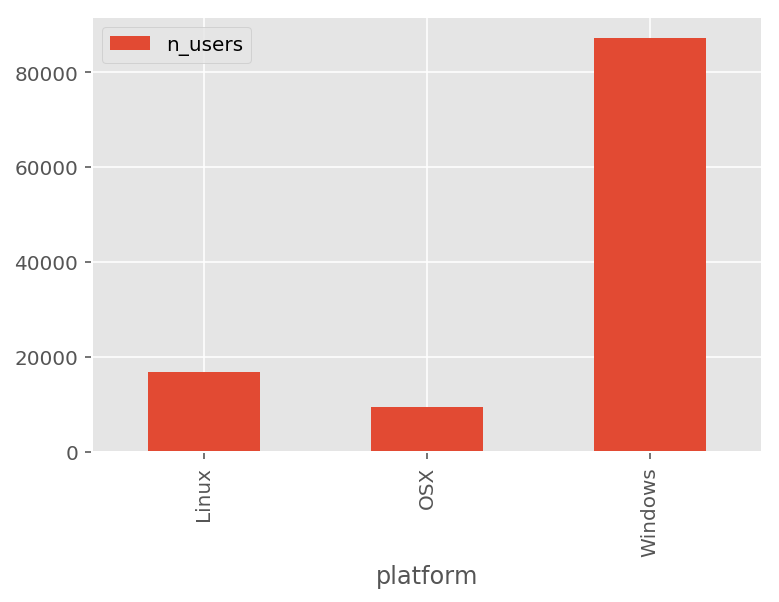

In [13]:
sysinfo_platforms.plot.bar()